In [68]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from pylsd.lsd import lsd
%matplotlib inline

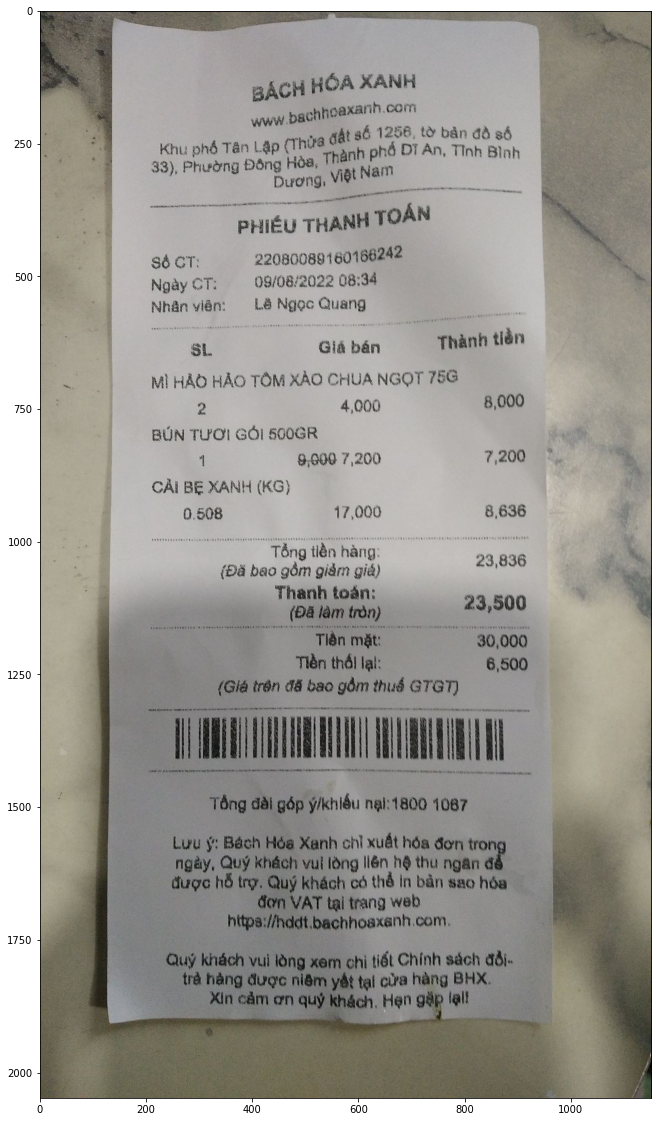

In [69]:
img = cv2.imread('/home/nhamnx28/ocr/ocr_receipt/test_folder/my_project/bhx_test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.show()

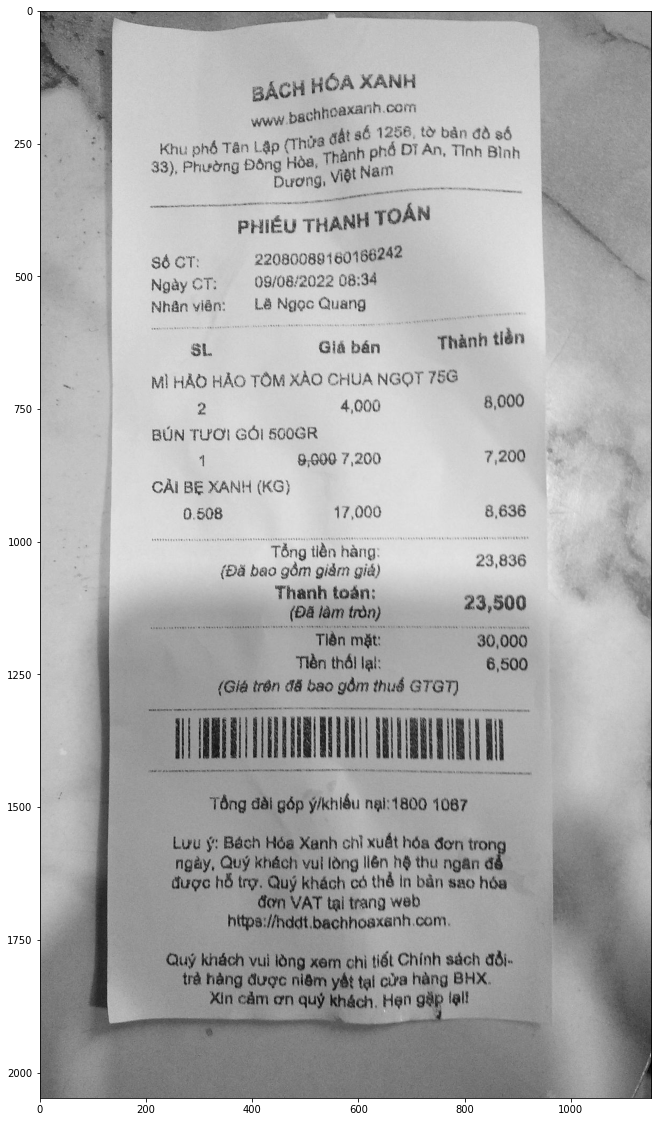

In [70]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(20, 20))
plt.imshow(gray, cmap='gray')
plt.show()

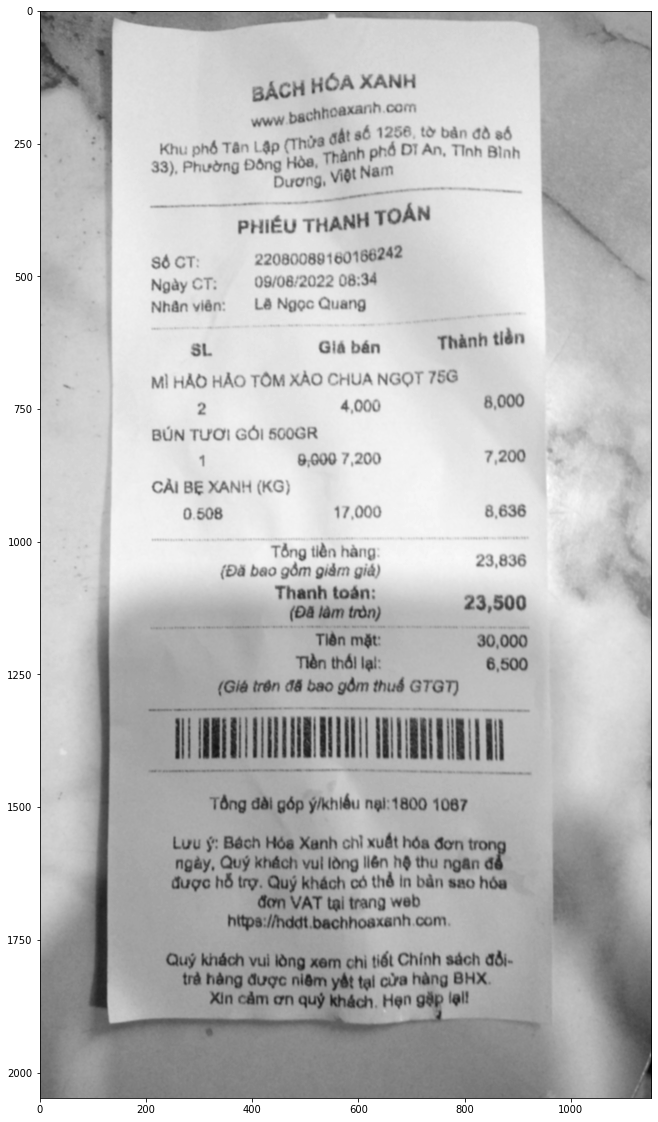

In [71]:
blur = cv2.GaussianBlur(gray, (7,7), 0)
plt.figure(figsize=(20, 20))
plt.imshow(blur, cmap='gray')
plt.show()

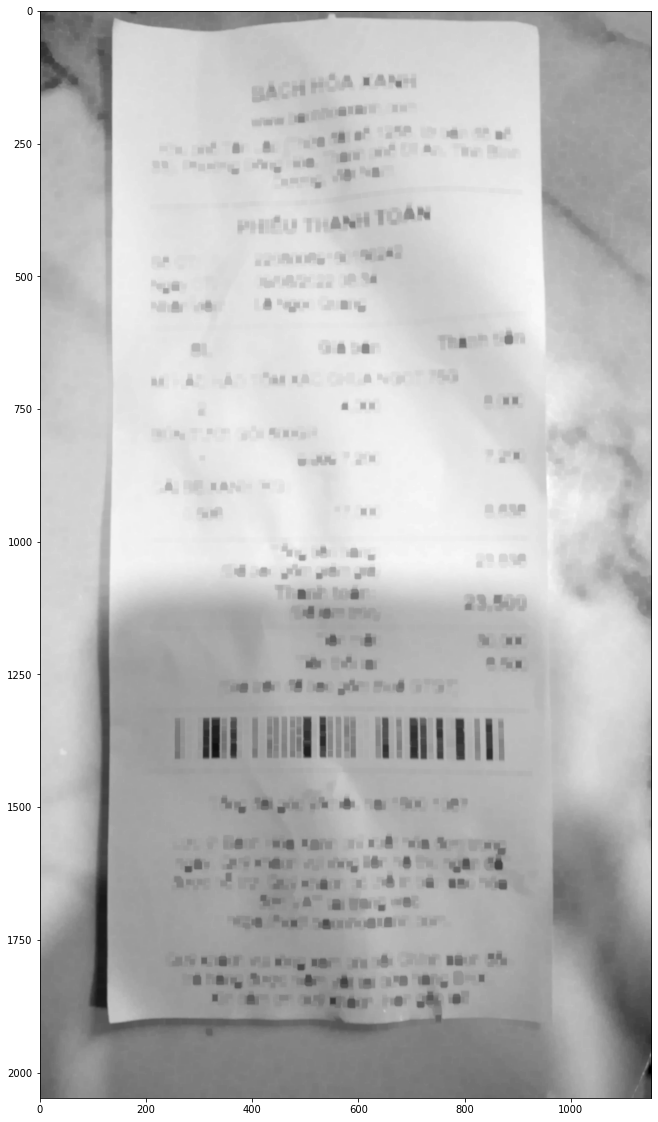

In [72]:
MORPH = 9
CANNY = 84
HOUGH = 25
# dilate helps to remove potential holes between edge segments
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))
dilated = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(20, 20))
plt.imshow(dilated, cmap='gray')
plt.show()

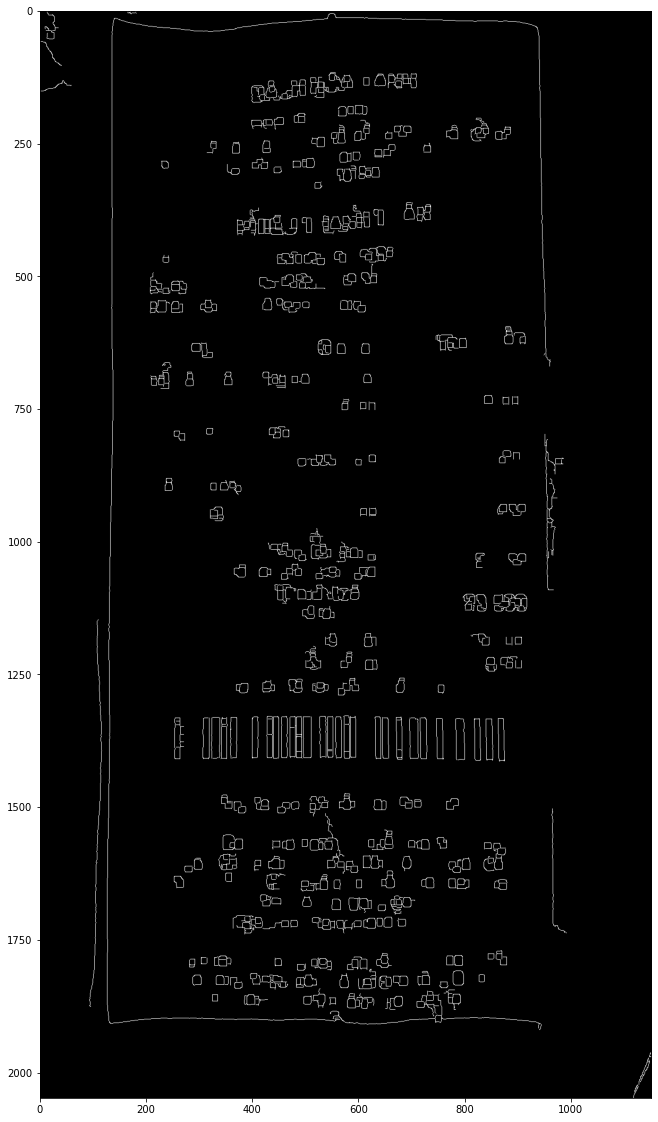

In [73]:
edged = cv2.Canny(dilated, 0, CANNY)
plt.figure(figsize=(20, 20))
plt.imshow(edged, cmap='gray')
plt.show()


In [74]:
lines = lsd(edged)
lines = lines.squeeze().astype(np.int32).tolist()
horizontal_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
vertical_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
for line in lines:
    x1, y1, x2, y2, _ = line
    if abs(x2 - x1) > abs(y2 - y1):
        (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[0])
        cv2.line(horizontal_lines_canvas, (max(x1 - 5, 0), y1), (min(x2 + 5, img.shape[1] - 1), y2), 255, 2)
    else:
        (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[1])
        cv2.line(vertical_lines_canvas, (x1, max(y1 - 5, 0)), (x2, min(y2 + 5, img.shape[0] - 1)), 255, 2)



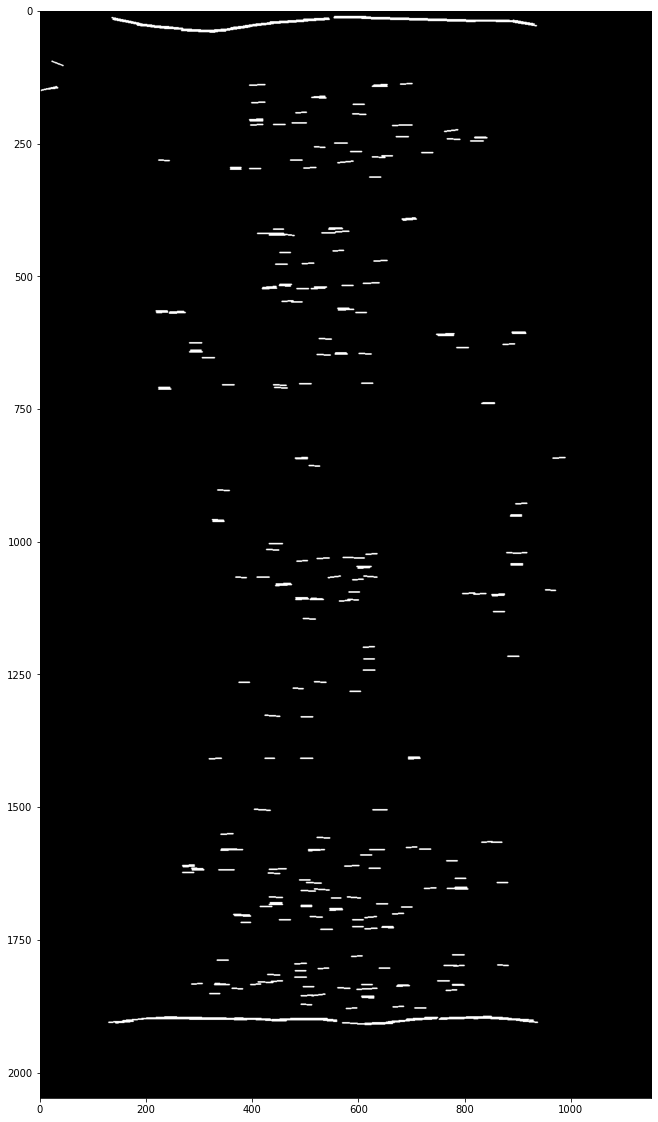

In [75]:
plt.figure(figsize=(20, 20))
plt.imshow(horizontal_lines_canvas, cmap='gray')
plt.show()

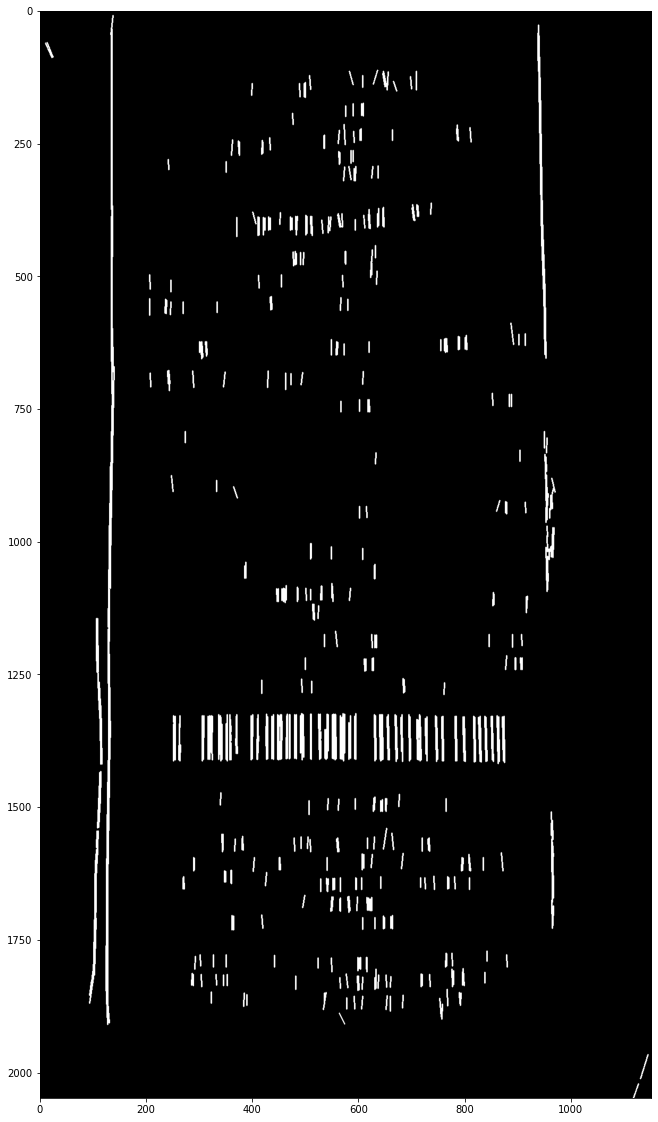

In [76]:
plt.figure(figsize=(20, 20))
plt.imshow(vertical_lines_canvas, cmap='gray')
plt.show()

In [77]:
lines = []
corners = []
# find the horizontal lines (connected-components -> bounding boxes -> final lines)
(contours, hierarchy) = cv2.findContours(horizontal_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
horizontal_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
for contour in contours:
    contour = contour.reshape((contour.shape[0], contour.shape[2]))
    min_x = np.amin(contour[:, 0], axis=0) + 2
    max_x = np.amax(contour[:, 0], axis=0) - 2
    left_y = int(np.average(contour[contour[:, 0] == min_x][:, 1]))
    right_y = int(np.average(contour[contour[:, 0] == max_x][:, 1]))
    lines.append((min_x, left_y, max_x, right_y))
    cv2.line(horizontal_lines_canvas, (min_x, left_y), (max_x, right_y), 1, 1)
    corners.append((min_x, left_y))
    corners.append((max_x, right_y))

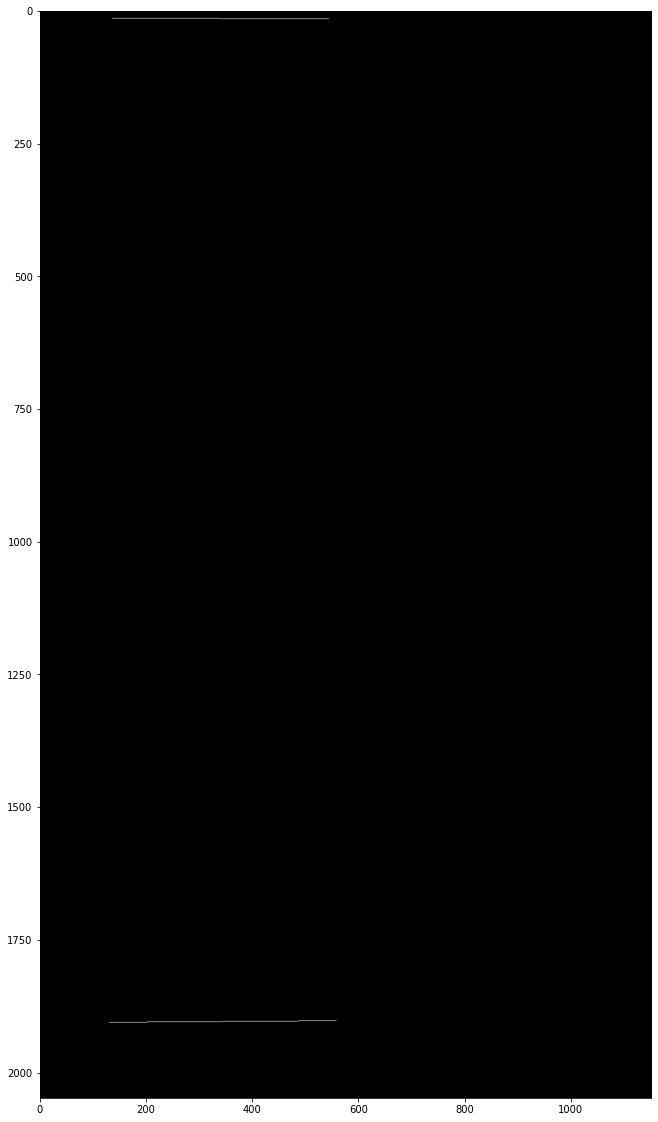

In [78]:
plt.figure(figsize=(20, 20))
plt.imshow(horizontal_lines_canvas, cmap='gray')
plt.show()

In [79]:
(contours, hierarchy) = cv2.findContours(vertical_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
vertical_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
for contour in contours:
    contour = contour.reshape((contour.shape[0], contour.shape[2]))
    min_y = np.amin(contour[:, 1], axis=0) + 2
    max_y = np.amax(contour[:, 1], axis=0) - 2
    top_x = int(np.average(contour[contour[:, 1] == min_y][:, 0]))
    bottom_x = int(np.average(contour[contour[:, 1] == max_y][:, 0]))
    lines.append((top_x, min_y, bottom_x, max_y))
    cv2.line(vertical_lines_canvas, (top_x, min_y), (bottom_x, max_y), 1, 1)
    corners.append((top_x, min_y))
    corners.append((bottom_x, max_y))

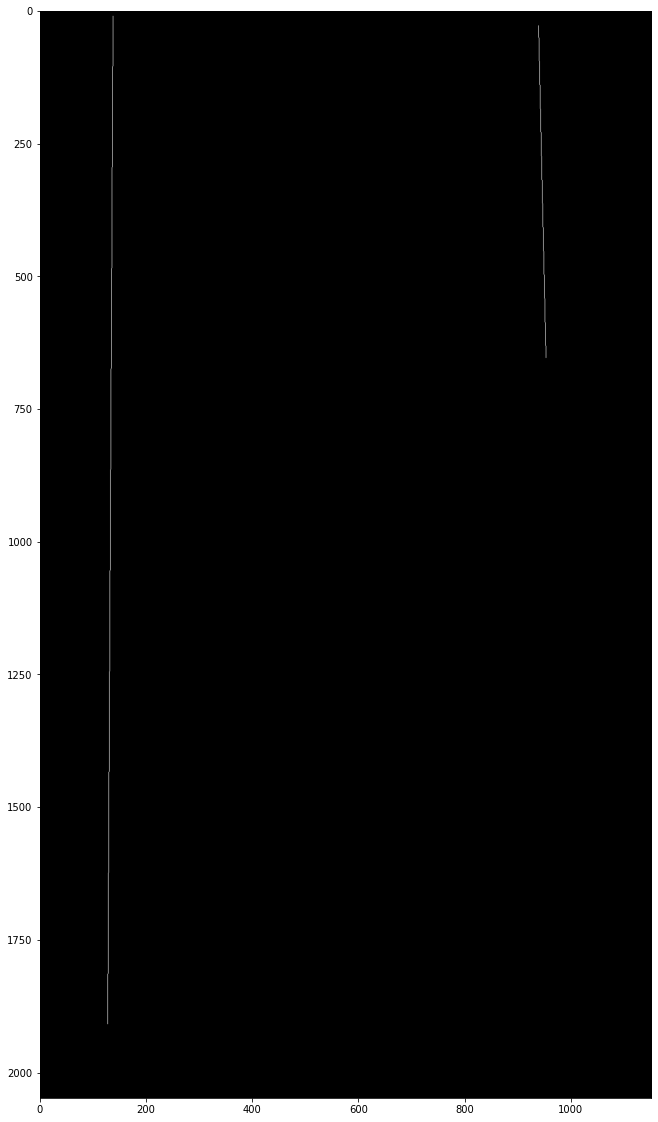

In [80]:
plt.figure(figsize=(20, 20))
plt.imshow(vertical_lines_canvas, cmap='gray')
plt.show()

In [81]:
corners_y, corners_x = np.where(horizontal_lines_canvas + vertical_lines_canvas == 2)

In [82]:
corners += zip(corners_x, corners_y)

In [41]:
corners

[(130, 1905),
 (557, 1902),
 (136, 15),
 (543, 16),
 (137, 11),
 (127, 1908),
 (938, 29),
 (952, 654),
 (137, 15)]

In [83]:
from scipy.spatial import distance as dist

def filter_corners(corners, min_dist=20):
    """Filters corners that are within min_dist of others"""
    def predicate(representatives, corner):
        return all(dist.euclidean(representative, corner) >= min_dist
                    for representative in representatives)

    filtered_corners = []
    for c in corners:
        if predicate(filtered_corners, c):
            filtered_corners.append(c)
    return filtered_corners

In [84]:
corners = filter_corners(corners)